In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [36]:
import os 
import gc 
import tensorflow as tf 
from keras import Sequential 
from keras.layers import Dense,BatchNormalization,Dropout,Activation,Flatten 
from keras.layers import Lambda, Input, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam 
from keras.models import Model 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint 
from keras.preprocessing.image import ImageDataGenerator,load_img 
from keras import regularizers

In [15]:
df = pd.read_csv('./utkface_sortAge.csv')
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df

,age,gender,ethnicity,image
0,1,1,0,109 146 198 132 169 221 134 171 223 137 174 22...
1,1,0,3,0 1 2 2 1 1 5 1 0 11 3 3 1 0 6 27 35 45 97 111...
2,1,0,3,54 64 91 55 66 95 56 72 105 58 76 113 67 85 12...
3,1,0,3,80 98 125 77 94 129 113 131 169 147 169 201 16...
4,1,0,3,63 55 96 58 51 94 72 67 112 83 80 126 91 90 13...
...,...,...,...,...
23703,115,1,1,175 211 219 177 210 219 176 206 215 166 195 20...
23704,116,1,0,12 76 199 41 60 149 60 87 123 96 118 167 119 1...
23705,116,1,0,61 77 93 70 88 104 77 97 115 81 102 123 85 109...
23706,116,1,2,193 208 210 183 201 206 177 197 207 160 184 19...


In [16]:
df.age.unique(), df.gender.unique()

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  95,  96,  99, 100, 101, 103, 105, 110, 111, 115, 116],
       dtype=int64),
 array([1, 0], dtype=int64))

In [17]:
X = np.array(df['image'].to_list())


In [20]:
X_reshaped1 = X.reshape(X.shape[0], -1, 3)
X_reshaped1.shape

ValueError: cannot reshape array of size 23708 into shape (23708,newaxis,3)

In [85]:
X_reshaped1 = X_reshaped1 / 255

In [21]:
df.describe()

,age,gender
count,23708.000000,23708.000000
mean,33.303484,0.477349
std,19.886112,0.499497
min,1.000000,0.000000
25%,23.000000,0.000000
50%,29.000000,0.000000
75%,45.000000,1.000000
max,116.000000,1.000000


In [22]:
df.age.value_counts()

26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
91        2
101       2
103       1
111       1
Name: age, Length: 104, dtype: int64

In [23]:
df['image'] = df['image'].map(lambda x: np.array(x.split(' '), dtype=np.uint8).reshape(50, 50, 3))

# Age prediction¶


In [25]:
X = np.array(df['image'].to_list())
X_reshaped = X.reshape(X.shape[0], 50, 50, 3)
X_reshaped.shape

(23708, 50, 50, 3)

In [32]:
X_reshaped = X_reshaped / 255

In [33]:
input_shape = X_reshaped.shape[1:] 
input_shape

(50, 50, 3)

In [34]:
y = df['age'].values

In [35]:
# Train test split
X_train, X_testval, y_train, y_testval = train_test_split(X_reshaped, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.4, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((14224, 50, 50, 3),
 (14224,),
 (5690, 50, 50, 3),
 (5690,),
 (3794, 50, 50, 3),
 (3794,))

In [37]:
# Data Generator 
datagen = ImageDataGenerator(rotation_range = 10, 
                             width_shift_range = 0.05, 
                             height_shift_range = 0.05, 
                             shear_range = 0.05, 
                             zoom_range = 0.1, 
#                              brightness_range = [0.9,1.1], 
                             horizontal_flip = True) 
datagen_val = ImageDataGenerator() 
datagen_test = ImageDataGenerator()

# Convert data gen
seed = 42
train_generator= datagen.flow(X_train, y_train, 
                              batch_size = 128,
                              shuffle = True, 
                              seed = seed) 
val_generator= datagen_val.flow(X_val, y_val, 
                                batch_size = 64,
                                shuffle = True, 
                                seed = seed) 

In [38]:
# Algorithms 
# Stop training when the validation loss metric has stopped decreasing for 5 epochs. 
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True) 
# Save the model with the minimum validation loss 
checkpoint = ModelCheckpoint('best_model.hdf5', monitor = 'val_loss', verbose = 1, mode = 'min',  save_best_only = True) 
# Reduce learning rate 
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, min_lr = 0.00001, mode = 'min', verbose = 1) 


In [40]:
# Import Model 
# MobileNetV2 - 14MB - 71.3% - 90.1% - 3.5M - 105
from tensorflow.keras.applications import MobileNetV2, EfficientNetB3
mbnv2 = MobileNetV2(input_shape = input_shape, include_top = False, weights = 'imagenet') 
# Definition Model 
def build_model(base_modelx):
    model = Sequential(base_modelx) 
    model.add(GlobalMaxPooling2D())
    model.add(Flatten())
    
    model.add(Dense(512,activation ='relu',kernel_regularizer=regularizers.l2(0.01))) 
    model.add(Dropout(0.1))
    
    model.add(Dense(256,activation ='relu',kernel_regularizer=regularizers.l2(0.01))) 
    model.add(Dropout(0.2))
    
    model.add(Dense(128,activation ='relu',kernel_regularizer=regularizers.l2(0.01))) 
    model.add(Dropout(0.3))
    
    model.add(Dense(1))
    print(model.summary())
    model.compile(optimizer='adam', loss='mse') 
    return model

model = build_model(mbnv2) 

#Model Trainning 
history = model.fit(train_generator, validation_data = val_generator, epochs = 10, callbacks = [checkpoint, reduce_lr]) 
# history = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 64, epochs = 100, callbacks = [checkpoint, reduce_lr]) 


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1280)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)              

C:\Users\Akhil\anaconda3\envs\ML\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
112/112 [==============================] - ETA: 0s - loss: 164.1046

KeyboardInterrupt: 

In [ ]:

# Ploting acc and loss 
from matplotlib import pyplot as plt
# #  "Accuracy"
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pd.DataFrame(history.history).plot();
plt.savefig('./MSE_loss_age.png')

In [36]:
valid_score = model.evaluate(X_test, y_test, verbose=1)
valid_score

119/119 [==============================] - 1s 9ms/step - loss: 72.5606


72.5605697631836

In [44]:
y_pred = np.round(model.predict(X_test))
y_pred


array([[28.],
       [ 8.],
       [48.],
       ...,
       [23.],
       [34.],
       [24.]], dtype=float32)

In [45]:
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))

MAE: 5.821033210332104



# Gender prediction¶


In [47]:
y = df['gender'].values
# Train test split
X_train, X_testval, y_train, y_testval = train_test_split(X_reshaped, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.4, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((14224, 50, 50, 3),
 (14224,),
 (5690, 50, 50, 3),
 (5690,),
 (3794, 50, 50, 3),
 (3794,))

In [48]:
# Data Generator 
datagen = ImageDataGenerator(rotation_range = 10, 
                             width_shift_range = 0.05, 
                             height_shift_range = 0.05, 
                             shear_range = 0.05, 
                             zoom_range = 0.1, 
#                              brightness_range = [0.9,1.1], 
                             horizontal_flip = True) 
datagen_val = ImageDataGenerator() 
datagen_test = ImageDataGenerator()

# Convert data gen
seed = 42
train_generator= datagen.flow(X_train, y_train, 
                              batch_size = 128,
                              shuffle = True, 
                              seed = seed) 
val_generator= datagen_val.flow(X_val, y_val, 
                                batch_size = 64,
                                shuffle = True, 
                                seed = seed) 

In [ ]:
# Algorithms 
# Stop training when the validation loss metric has stopped decreasing for 5 epochs. 
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True) 
# Save the model with the minimum validation loss 
checkpoint = ModelCheckpoint('best_model_gender.hdf5', monitor = 'val_loss', verbose = 1, mode = 'min',  save_best_only = True) 
# Reduce learning rate 
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, min_lr = 0.00001, mode = 'min', verbose = 1) 


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_7 (Glob (None, 1280)              0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               655872    
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)              

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
112/112 [==============================] - 14s 123ms/step - loss: 0.7460 - accuracy: 0.8708 - val_loss: 0.7763 - val_accuracy: 0.8633

Epoch 00002: val_loss improved from 2.17959 to 0.77631, saving model to best_model.hdf5
Epoch 3/100
112/112 [==============================] - 13s 118ms/step - loss: 0.3731 - accuracy: 0.8820 - val_loss: 1.8109 - val_accuracy: 0.7555

Epoch 00003: val_loss did not improve from 0.77631
Epoch 4/100
112/112 [==============================] - 13s 117ms/step - loss: 0.3000 - accuracy: 0.8922 - val_loss: 0.5823 - val_accuracy: 0.8404

Epoch 00004: val_loss improved from 0.77631 to 0.58235, saving model to best_model.hdf5
Epoch 5/100
112/112 [==============================] - 13s 118ms/step - loss: 0.2668 - accuracy: 0.8996 - val_loss: 1.6625 - val_accuracy: 0.7104

Epoch 00005: val_loss did not improve from 0.58235
Epoch 6/100
112/112 [==============================] - 14s 122ms/step - loss: 0.2467 - accuracy: 0.9044 - val_loss: 1.0315 - val_accur

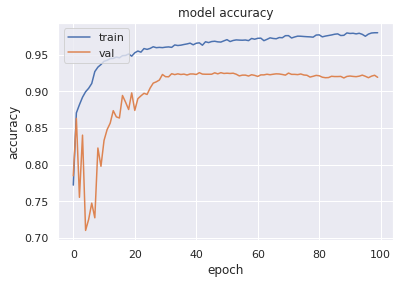

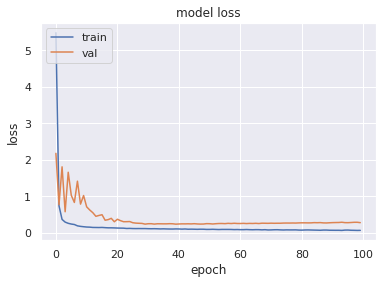

In [49]:
# Import Model 
# MobileNetV2 - 14MB - 71.3% - 90.1% - 3.5M - 105
from tensorflow.keras.applications import MobileNetV2, EfficientNetB3
mbnv2 = MobileNetV2(input_shape = input_shape, include_top = False, weights = 'imagenet') 
# Definition Model 
def build_model(base_modelx):
    model = Sequential(base_modelx) 
    model.add(GlobalMaxPooling2D())
    model.add(Flatten())
    
    model.add(Dense(512,activation ='relu',kernel_regularizer=regularizers.l2(0.01))) 
    model.add(Dropout(0.1))
    
    model.add(Dense(256,activation ='relu',kernel_regularizer=regularizers.l2(0.01))) 
    model.add(Dropout(0.2))
    
    model.add(Dense(128,activation ='relu',kernel_regularizer=regularizers.l2(0.01))) 
    model.add(Dropout(0.3))
    
    model.add(Dense(1, activation = 'sigmoid',kernel_regularizer=regularizers.l2(0.01)))
    print(model.summary())
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
    return model

model = build_model(mbnv2) 

#Model Trainning 
history = model.fit(train_generator, validation_data = val_generator, epochs = 100, callbacks = [checkpoint, reduce_lr]) 
# history = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 64, epochs = 100, callbacks = [checkpoint, reduce_lr]) 

# Ploting acc and loss 
from matplotlib import pyplot as plt
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

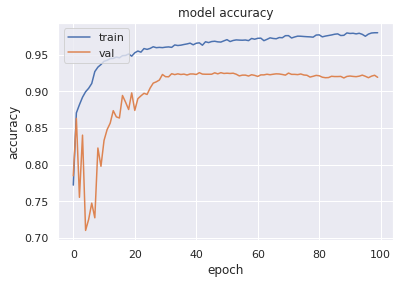

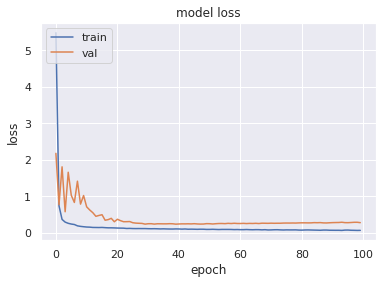

In [50]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('/kaggle/working/Accuracy_gender.png')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('/kaggle/working/Loss_gender.png')
plt.show()

In [52]:
valid_score = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy for test set: {0}'.format(valid_score[1]))

119/119 [==============================] - 1s 10ms/step - loss: 0.3094 - accuracy: 0.9143
Accuracy for test set: 0.9143384099006653


In [55]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)
y_pred

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [56]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1894
           1       0.92      0.91      0.91      1900

    accuracy                           0.91      3794
   macro avg       0.91      0.91      0.91      3794
weighted avg       0.91      0.91      0.91      3794



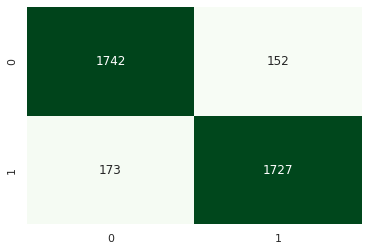

In [57]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, fmt='d');